# Summary of the current situation

M507 is installed flipped and then rotated by 45 degrees

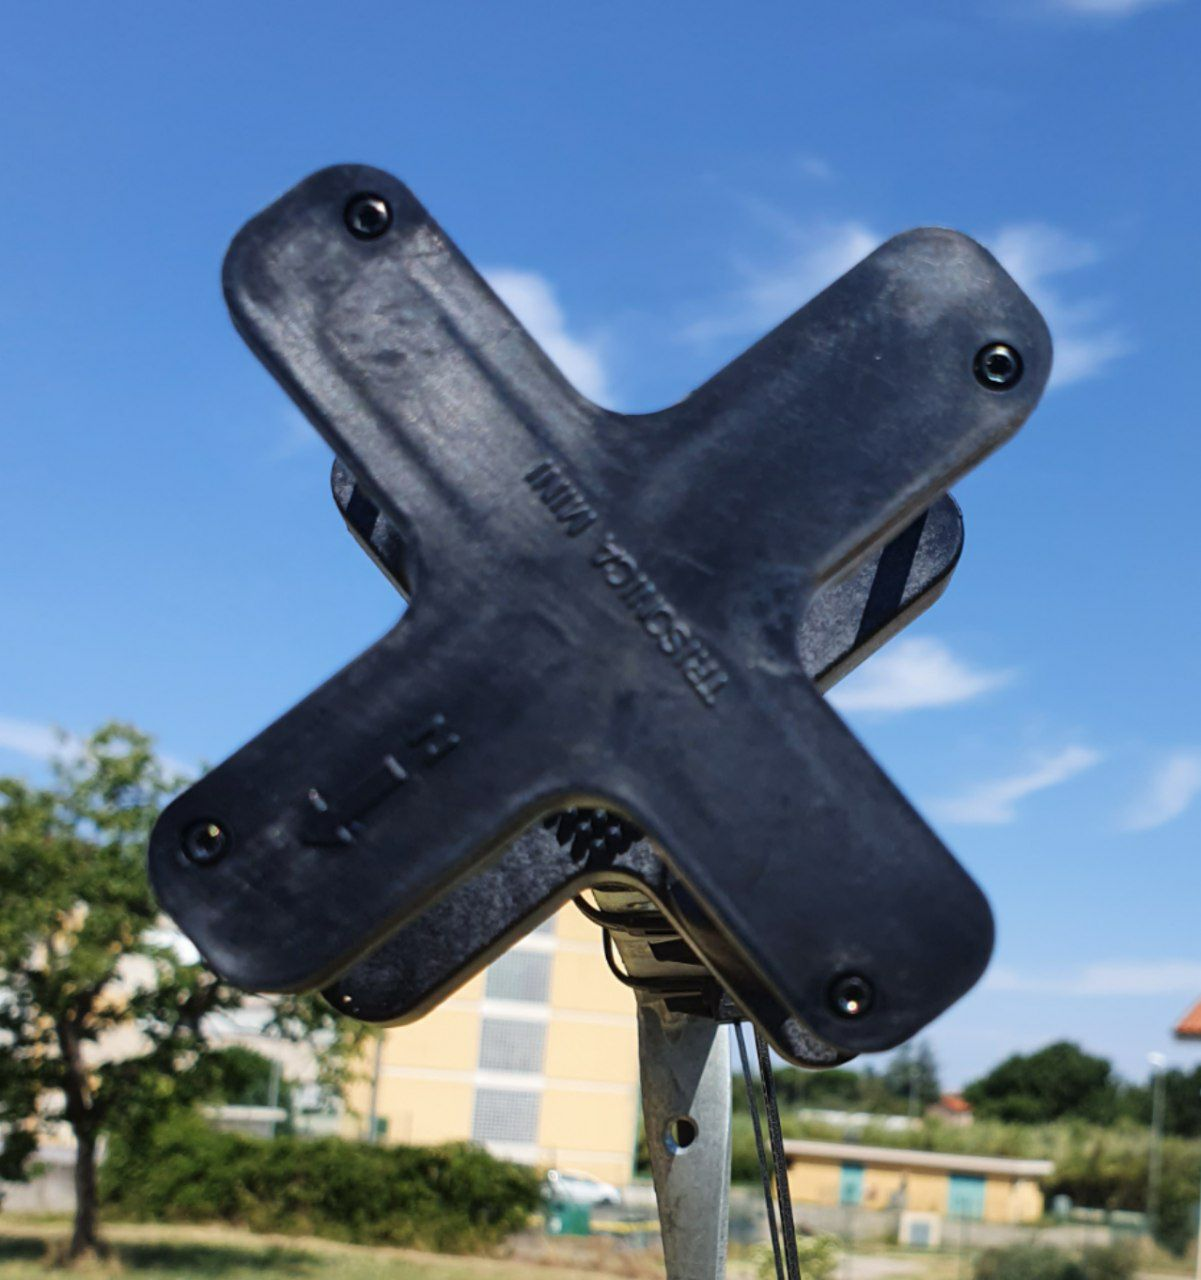

# Init

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from wind_tools import *  
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib
#matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt
sns.set()
import plotly.express as px

matplotlib.rcParams['figure.figsize'] = (20,12)

In [ ]:
from scipy.spatial.transform import Rotation as R
from scipy.optimize import minimize

In [ ]:
from functools import partial
# monkey patching from_euler to avoid forgetting adding degrees=True
R.from_euler = partial(R.from_euler, degrees=True)

## Load data

In [ ]:
proc_dir = Path("2020_data/data_20200724_final_field_install/processed")

# default is 2 mins aggregated data
wm1_path = proc_dir / "eddypro_WM1_2min_full_output_2020-08-01T085655_exp.csv"
# raw data no rotation nor axis renaming on it
m7rw_path = proc_dir / "eddypro_TRS_M507_raw_full_output_2020-07-31T185919_exp.csv"


cache_dir = Path("data_cache")
start_date = '2020-07-24 13:00:00'
end_date = '2020-08-03 10:00:00'

wind_cols = ['u_unrot','v_unrot', 'w_unrot', 'wind_speed', 'wind_dir']
wind_comp_rename = {'u_unrot': 'u', 'v_unrot': 'v', 'w_unrot': 'w'}

In [ ]:
wm1, m7rw= map(
    lambda p: load_ep_cache(p, cache_dir= cache_dir)
    .loc[start_date:end_date]
    .loc[:,wind_cols]
    .rename(columns=wind_comp_rename),
    [wm1_path, m7rw_path])

In [ ]:
wm1 = wm1.interpolate() # remove a few NaNs

In [ ]:
wm1r = rotate_wind_ang(wm1, 310)
wm1r = add_hor_wind_speed(wm1r)

In [ ]:
filt = filter_by_wind_dir(wm1r, 250, 10)

wm1f = wm1r[filt]

m7f =m7rw[filt]

In [ ]:
m7rw.describe()

,u,v,w,wind_speed,wind_dir
count,5205.000000,5205.000000,5205.000000,5205.000000,5205.000000
mean,-0.140493,-0.155592,0.219578,0.903002,118.515122
std,0.920693,0.540475,0.125430,0.657507,98.453226
min,-2.859030,-2.152510,-0.032108,0.033174,0.099878
25%,-0.919067,-0.546642,0.120192,0.386913,31.187800
50%,0.152308,0.027346,0.198967,0.706044,65.354700
75%,0.479667,0.213033,0.298433,1.304680,196.087000
max,3.020720,1.541330,1.026130,3.393000,359.985000


In [ ]:
wm1r.describe()

,u,v,w,wind_speed,wind_dir,wind_speed_hor
count,5205.000000,5205.000000,5205.000000,5205.000000,5205.000000,5205.000000
mean,-0.391039,0.135722,0.016498,1.011107,183.523884,1.002761
std,1.035496,0.512442,0.118134,0.705709,115.507945,0.707453
min,-3.452527,-1.442855,-0.523442,0.024813,0.067376,0.008209
25%,-1.283939,-0.211699,-0.046525,0.428801,69.336700,0.421403
50%,0.008997,0.062872,0.018258,0.823097,156.276000,0.813832
75%,0.347590,0.417332,0.085058,1.497390,304.883000,1.489298
max,2.085213,3.008783,0.619600,3.527280,359.690000,3.522679


## Helper funcs

In [ ]:
def apply_rotation_on_data(ang, seq='XYZ'):
    rotation = R.from_euler(seq, ang, degrees=True)
    x = m7rw[['u', 'v', 'w']].to_numpy()
    pred = rotation.apply(x)

    m7r = pd.DataFrame(pred, columns = ['u', 'v', 'w'])
    m7r.index = m7rw.index

    m7r = add_hor_wind_speed(m7r)
    return m7r

In [ ]:
def vecs3d_legend(name="", colors=['r', 'g', 'b', 'fuchsia', 'yellow', 'cyan'], labels=['u', 'v', 'w', 'u reference system', 'v reference system', 'w reference system']):
    handles = []
    for col, label in zip(colors, labels):
        handles.append(mpatches.Patch(color=col, label=label))
    
    plt.legend(handles=handles)

# Why it should work

First of all in theory there is no reason why a flipped anemometer should not work, then the wind speed is really good, so there must be a way to have a rotation so the components can match

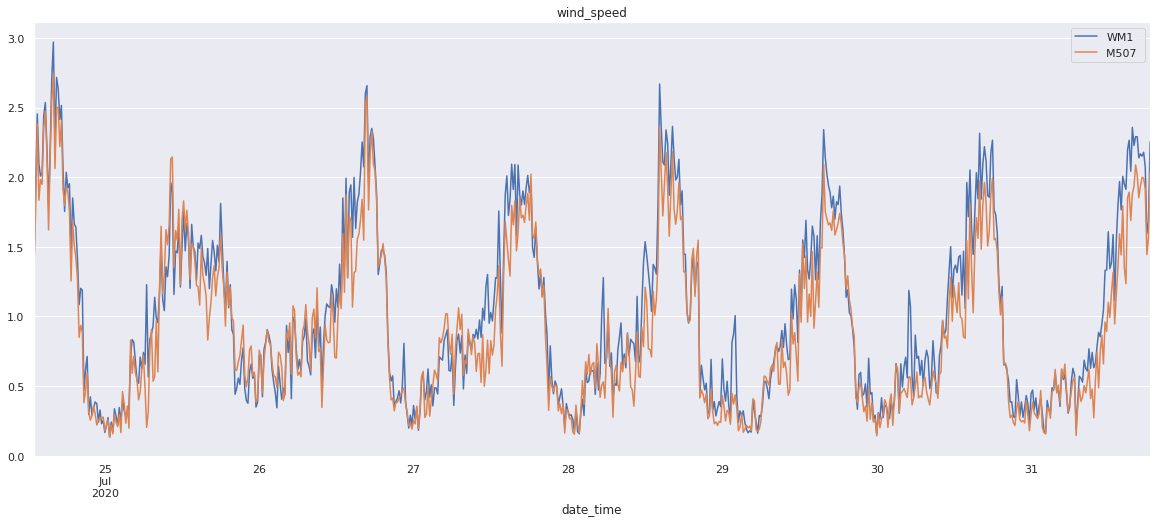

In [ ]:
m7rw = add_wind_speed(m7rw)
axes = plot_components(resample([wm1r, m7rw], '15min'),['wind_speed'], plot_info=[{'label': 'WM1'}, {'label': f'M507 '}], vertical=False, figsize=(20,8))

## Why it may not work

Trisonica has a resolution of 0.1 m/s and an accuracy of +/- 0.1 m/s [datasheet](https://anemoment.com/wp-content/uploads/2019/03/TSM-W-and-W-Sensor-datasheet.pdf).

The problem is that the modulo of vertical wind has a mean of `0.09 m/s` and a standard deviation of `0.11 m/s`

So there the variable that needs to be measured and the error are really similar

In [ ]:
wm1.w.abs().std()

0.0781780072039949

In [ ]:
wm1.w.describe()

count    5205.000000
mean        0.016498
std         0.118134
min        -0.523442
25%        -0.046525
50%         0.018258
75%         0.085058
max         0.619600
Name: w, dtype: float64

Other issue is the big difference between the horizontal and vertical wind (an order of magnitude)

# Rotations that should be done in theory

Checking only the horizontal wind speed and the w.
Ignoring the North Offset for simplification of the procedure and reducing the number of potential errors.

So all **rotation on axis y will be 0**

## Hypothesis 1

both `u` and `v` in the Trisonica reference system are inverted compared to the EP one

rotation expressed in euler angles is:

`[ -90, 0, -135]` on 'XYZ'


### Checking visually the rotation
it brings to the correct reference system (note u and v point on the opposite direction of the TRS reference system)

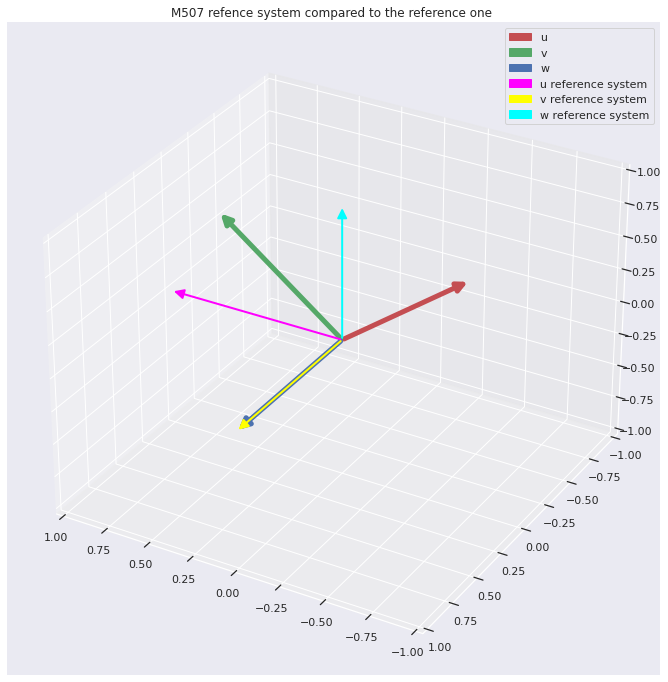

In [ ]:
ang_1 = [  -90,    0., -135]
rotation_1 = R.from_euler('XYZ', ang_1, degrees=True)

ax = plt.figure().add_subplot(111, projection='3d')
ax.set_title("M507 refence system compared to the reference one ")
plot_vecs3d(rotation_1.apply(v0), colors=['r', 'g', 'b'], ax=ax, lw=5 )
plot_vecs3d(v0, colors=['fuchsia', 'yellow', 'cyan'], ax=ax, lw=2) # plot origins as reference only on the last one

vecs3d_legend()
ax.view_init(azim=120)

### Checking the data

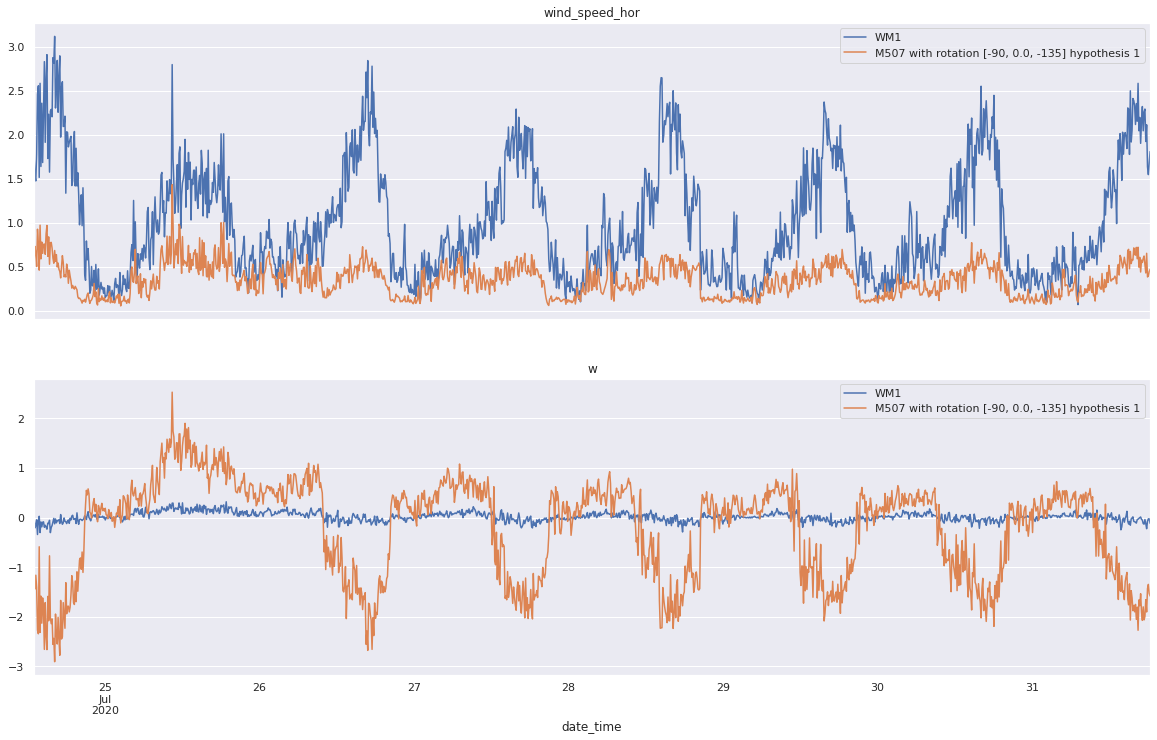

In [ ]:
axes = plot_components(resample([wm1r, apply_rotation_on_data(ang_1)], '8min'),('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': f'M507 with rotation {ang_1} hypothesis 1'}], vertical=False)

It is really bad so move on

## Hypothesis 2

only the `u` in the Trisonica reference system is inverted compared to the EP one (as written in the spec sheet)

required steps:
- invert u
- rotation expressed in euler angles is:
    `[ -90, 0, 45]` on 'XYZ'


### Checking visually the rotation
it brings to the correct reference system

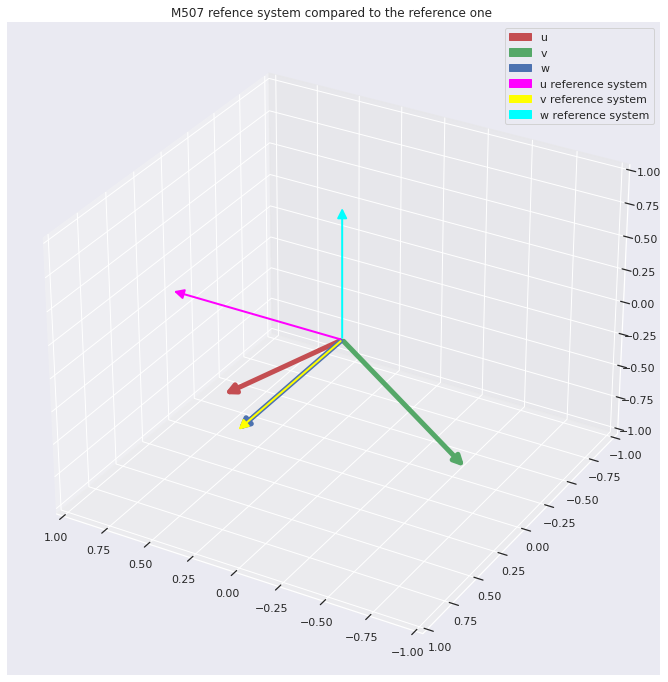

In [ ]:
ang_2 = [  -90,    0., 45]
rotation_2 = R.from_euler('XYZ', ang_2, degrees=True)

ax = plt.figure().add_subplot(111, projection='3d')
ax.set_title("M507 refence system compared to the reference one ")
# note here u has not been inverted because v0 is already a right handed reference system
plot_vecs3d(rotation_2.apply(v0), colors=['r', 'g', 'b'], ax=ax, lw=5 )
plot_vecs3d(v0, colors=['fuchsia', 'yellow', 'cyan'], ax=ax, lw=2) # plot origins as reference only on the last one

vecs3d_legend()
ax.view_init(azim=120)

### Checking the data

In [ ]:
x_2 = m7rw[['u', 'v', 'w']].to_numpy()
x_2[:, 0] = - x_2[:,0] # inverting u 

rotated_2 = rotation_2.apply(x_2)

m7r_2 = pd.DataFrame(rotated_2, columns = ['u', 'v', 'w'])
m7r_2.index = m7rw.index

m7r_2 = add_hor_wind_speed(m7r_2)

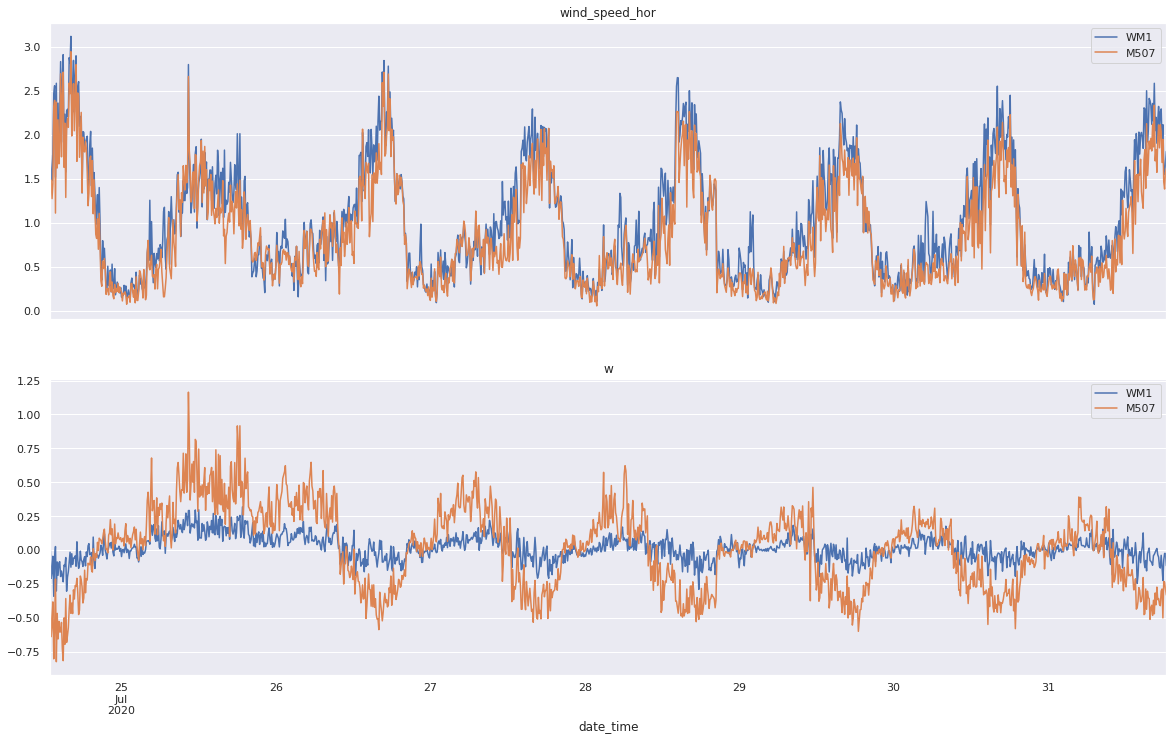

In [ ]:
axes = plot_components(resample([wm1r, m7r_2], '8min'),('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': f'M507'}], vertical=False)

This is much much better but still bad.

Since the installation in the field is not perfect one idea is trying all possible angles similar the the theoretical one to find if there is something that can improve the w

### Find a similar angle that can be better with this rotation

In [ ]:
def loss(x,y):
    return (((x[:, 2]- y[:, 2])**2)).mean() 

In [ ]:
# angles ranges +/- 10 for the x and +/- 35 for the y (this should influence more the wind)
X_angs = np.arange(-100, -80, dtype=float)
Y_angs = np.array([0])
Z_angs = np.arange(10, 80, dtype=float)

In [ ]:
x_2 # already defined and with inverted u
y_true = wm1[['u', 'v', 'w']].to_numpy()

In [ ]:
results = pd.Series(np.zeros((X_angs.shape[0]*Y_angs.shape[0]*Z_angs.shape[0],), dtype=float))

In [ ]:
test_angles = np.array(list(itertools.product(X_angs,Y_angs, Z_angs)))

In [ ]:
def model(ang):
    return R.from_euler('XYZ', ang).apply(x_2)

In [ ]:
def brute_force_optimize():
    for i, angs in enumerate(test_angles):
        pred = model(angs)
        results[i] = loss(y_true, pred)

In [ ]:
brute_force_optimize()

In [ ]:
results.nsmallest(10)

23     0.018284
93     0.018376
163    0.018498
24     0.018583
94     0.018620
233    0.018649
22     0.018653
164    0.018687
234    0.018782
92     0.018803
dtype: float64

In [ ]:
test_angles[results.nsmallest(10).index]

array([[-100.,    0.,   33.],
       [ -99.,    0.,   33.],
       [ -98.,    0.,   33.],
       [-100.,    0.,   34.],
       [ -99.,    0.,   34.],
       [ -97.,    0.,   33.],
       [-100.,    0.,   32.],
       [ -98.,    0.,   34.],
       [ -97.,    0.,   34.],
       [ -99.,    0.,   32.]])

In [ ]:
x_2_opt = m7rw[['u', 'v', 'w']].to_numpy()
x_2_opt[:, 0] = - x_2_opt[:,0] # inverting u 
rotation_2_opt = R.from_euler('XYZ', [-100.,    0.,   33.], degrees=True) 
rotated_2_opt = rotation_2_opt.apply(x_2_opt)

m7r_2_opt = pd.DataFrame(rotated_2_opt, columns = ['u', 'v', 'w'])
m7r_2_opt.index = m7rw.index

m7r_2_opt = add_hor_wind_speed(m7r_2_opt)

In [ ]:
m7r_2[['wind_speed_hor', 'w']].describe()

,wind_speed_hor,w
count,5205.000000,5205.000000
mean,0.851729,0.010677
std,0.646237,0.323083
min,0.031353,-1.192359
25%,0.350858,-0.222556
50%,0.647084,0.033646
75%,1.239061,0.206838
max,3.339311,1.375160


In [ ]:
wm1r[['wind_speed_hor', 'w']].describe()

,wind_speed_hor,w
count,5205.000000,5205.000000
mean,1.002761,0.016498
std,0.707453,0.118134
min,0.008209,-0.523442
25%,0.421403,-0.046525
50%,0.813832,0.018258
75%,1.489298,0.085058
max,3.522679,0.619600


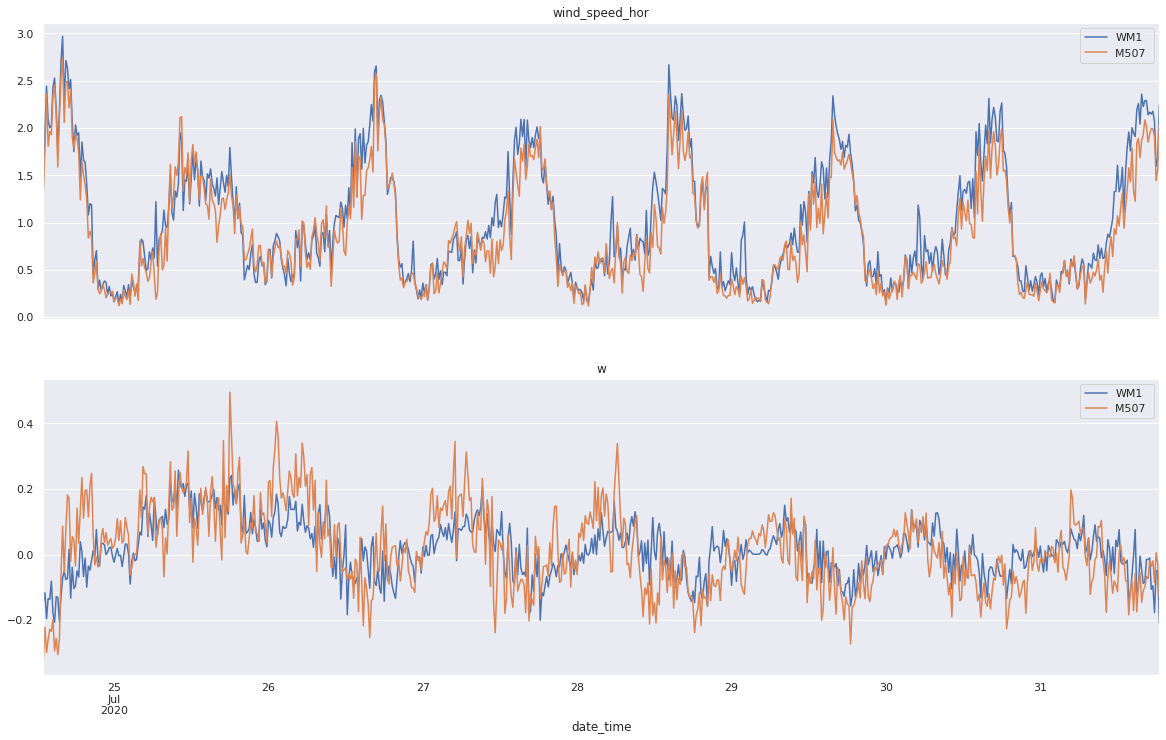

In [ ]:
axes = plot_components(resample([wm1r, m7r_2_opt], '15min'),['wind_speed_hor', 'w'], plot_info=[{'label': 'WM1'}, {'label': f'M507 '}], vertical=False)

This can look okay

### Filtering by wind dir

Now using data filtered by wind directions of 230° N +/- 30 and 50° N +/- 30 which is approximately the orientation in the field

Filtering wind seems to slightly improve

Text(0.5, 1.0, 'Wind Speed after filtering')

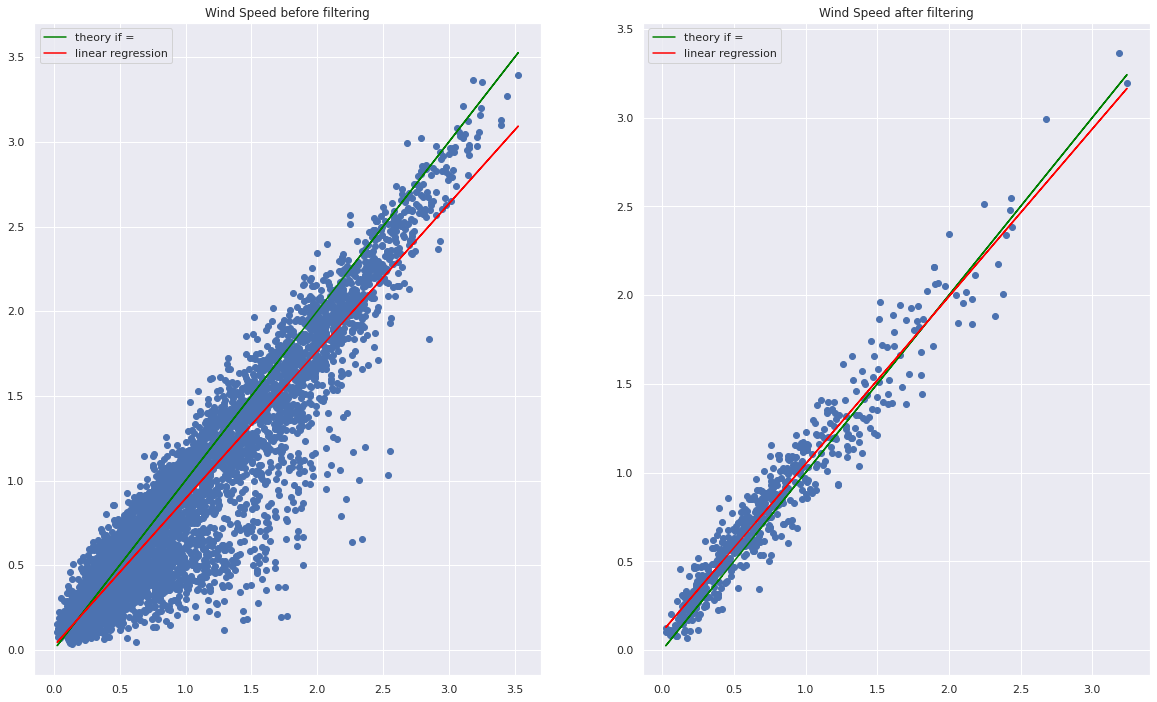

In [ ]:
axes = get_ax(1,2)
plot_components_scatter([wm1r, m7rw] ,['wind_speed'], figsize=(18,10), linreg=True, ax=axes[0])
plot_components_scatter([wm1f, m7f] ,['wind_speed'], figsize=(18,10), linreg=True, ax=axes[1])
axes[0].set_title("Wind Speed before filtering")
axes[1].set_title("Wind Speed after filtering")

In [ ]:
x_2f = m7f[['u', 'v', 'w']].to_numpy()
x_2f[:, 0] = - x_2f[:,0] # inverting u 

rotated_2f = rotation_2.apply(x_2f)

m7r_2f = pd.DataFrame(rotated_2f, columns = ['u', 'v', 'w'])
m7r_2f.index = m7f.index

m7r_2f = add_hor_wind_speed(m7r_2f)

In [ ]:
mid_split = '20200727-2100'

/home/simone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/simone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/simone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/simone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 

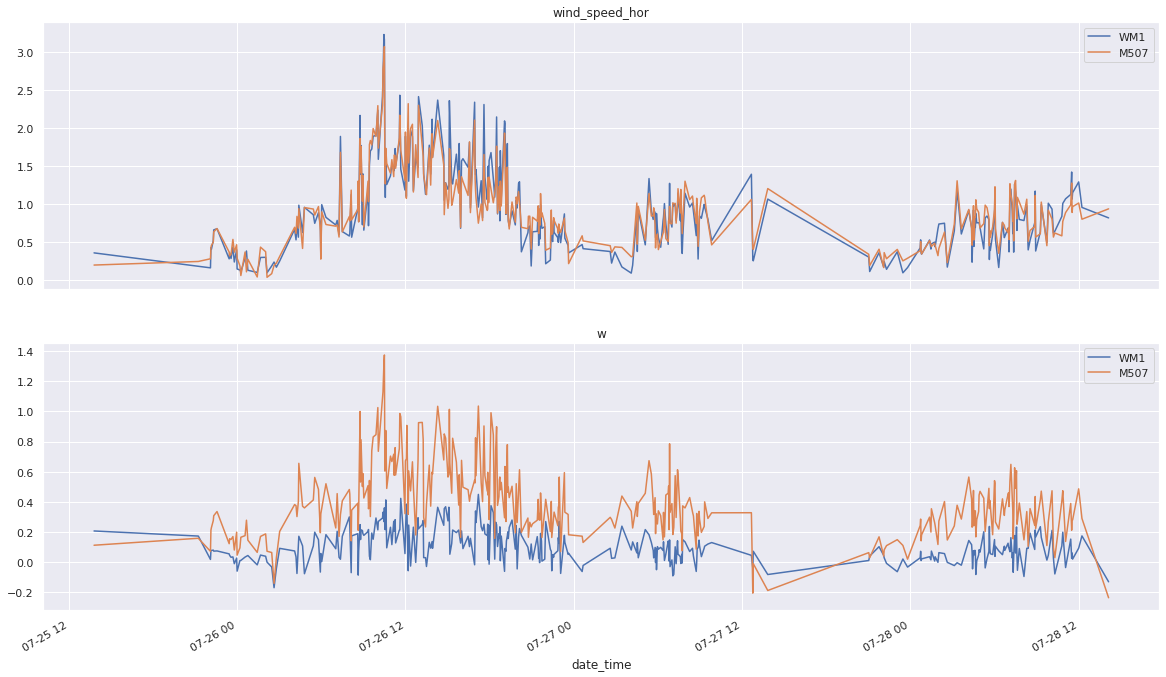

In [ ]:
axes = plot_components([wm1f[:mid_split], m7r_2f[:mid_split]],('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': f'M507'}], vertical=False)

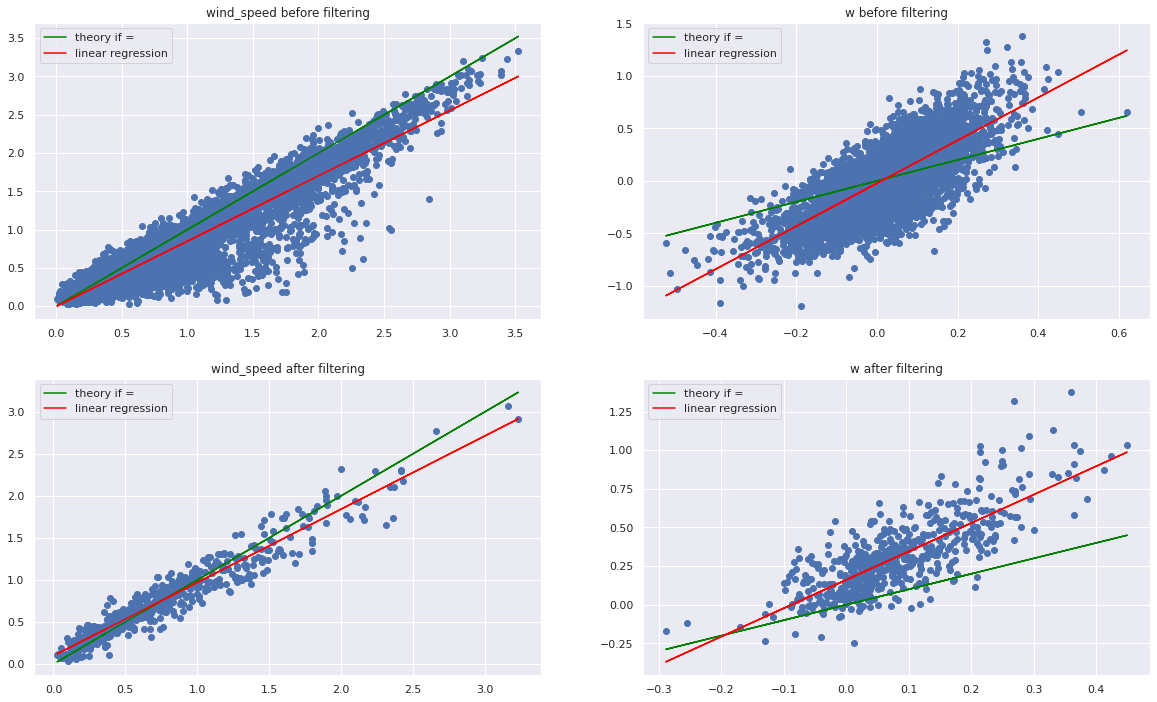

In [ ]:
axes = get_ax(2,2)
plot_components_scatter([wm1r, m7r_2] ,['wind_speed_hor', 'w'], figsize=(18,10), linreg=True, ax=axes[0])
plot_components_scatter([wm1f, m7r_2f] ,['wind_speed_hor', 'w'], figsize=(18,10), linreg=True, ax=axes[1])
for i, (when, comp) in enumerate(itertools.product(['before filtering', 'after filtering'], ['wind_speed', 'w'], )):
    axes[i//2, i%2].set_title(f"{comp} {when}")


#### Find a similar angle that can be better with filtered wind

Since the filtering have made the vertical component worse trying to find by optimization another angle

In [ ]:
def loss(x,y):
    # mean square error of the w component
    return (((x[:, 2]- y[:, 2])**2)).mean() 

In [ ]:
X_angs = np.arange(-100, -80, dtype=float)
Y_angs = np.array([0])
Z_angs = np.arange(10, 80, dtype=float)

In [ ]:
x_2f # already defined and with inverted u
y_truef = wm1f[['u', 'v', 'w']].to_numpy()

In [ ]:
results = pd.Series(np.zeros((X_angs.shape[0]*Y_angs.shape[0]*Z_angs.shape[0],), dtype=float))

In [ ]:
test_angles = np.array(list(itertools.product(X_angs,Y_angs, Z_angs)))

In [ ]:
def model(ang):
    return R.from_euler('XYZ', ang).apply(x_2f)

In [ ]:
def brute_force_optimize():
    for i, angs in enumerate(test_angles):
        pred = model(angs)
        results[i] = loss(y_truef, pred)

In [ ]:
brute_force_optimize()

In [ ]:
results.nsmallest(10)

21     0.008482
20     0.008549
90     0.008573
160    0.008636
91     0.008648
230    0.008736
161    0.008851
300    0.008872
299    0.008879
229    0.008881
dtype: float64

In [ ]:
test_angles[results.nsmallest(10).index]

array([[-100.,    0.,   31.],
       [-100.,    0.,   30.],
       [ -99.,    0.,   30.],
       [ -98.,    0.,   30.],
       [ -99.,    0.,   31.],
       [ -97.,    0.,   30.],
       [ -98.,    0.,   31.],
       [ -96.,    0.,   30.],
       [ -96.,    0.,   29.],
       [ -97.,    0.,   29.]])

In [ ]:
x_3_opt = m7rw[['u', 'v', 'w']].to_numpy()
x_3_opt[:, 0] = - x_3_opt[:,0] # inverting u 
rotation_3_opt = R.from_euler('XYZ', [-100.,    0.,   30.], degrees=True) 
rotated_3_opt = rotation_3_opt.apply(x_3_opt)

m7r_3_opt = pd.DataFrame(rotated_3_opt, columns = ['u', 'v', 'w'])
m7r_3_opt.index = m7rw.index

m7r_3_opt = add_hor_wind_speed(m7r_3_opt)

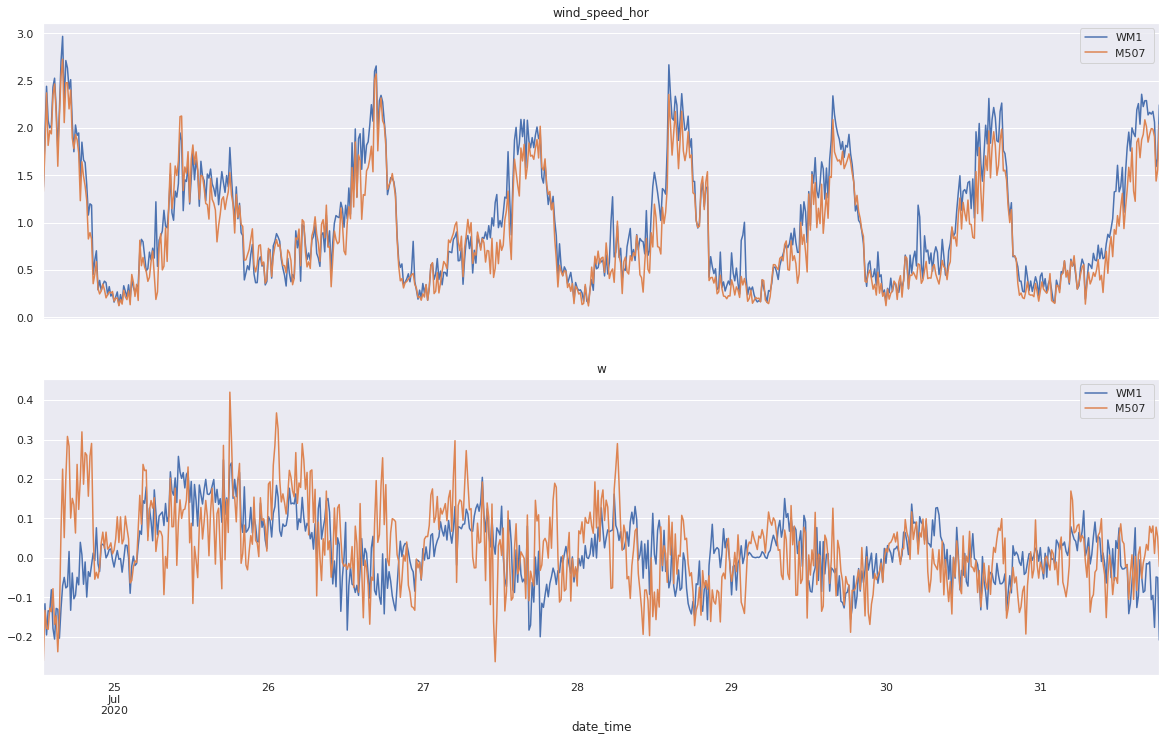

In [ ]:
axes = plot_components(resample([wm1r, m7r_3_opt], '15min'),('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': f'M507 '}], vertical=False)

In [ ]:
x_3f = m7f[['u', 'v', 'w']].to_numpy()
x_3f[:, 0] = - x_3f[:,0] # inverting u 

rotated_3f = rotation_3_opt.apply(x_3f)

m7r_3f = pd.DataFrame(rotated_3f, columns = ['u', 'v', 'w'])
m7r_3f.index = m7f.index

m7r_3f = add_hor_wind_speed(m7r_3f)

/home/simone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/simone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/simone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/simone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 

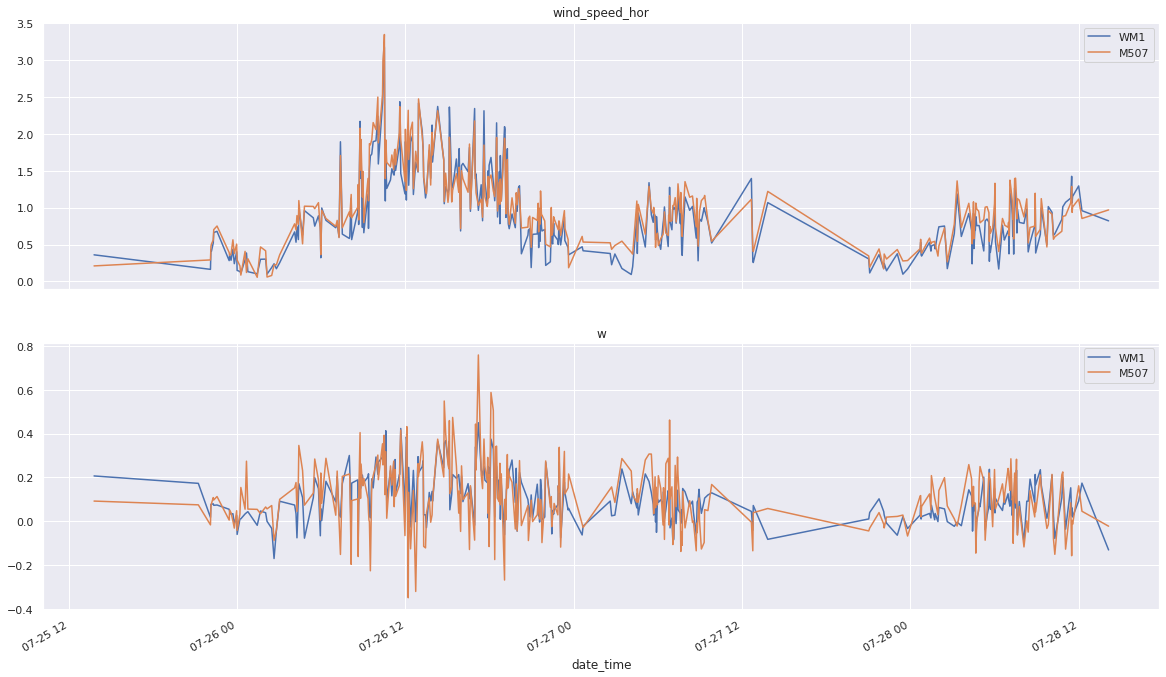

In [ ]:
axes = plot_components([wm1f[:mid_split], m7r_3f[:mid_split]],('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': f'M507'}], vertical=False)

# Conclusion

The Trisonica flipped does seem to work well, the system of findind an angles that improve the situation gives decent results (which are also valid across days) but it is not great the idea behid it.

For me the way forward is:
- double checking the installation in the field to understand if the brute force angles can make any sense
- try to understand that even if with this poor performance we can still get fluxes that can be someway useful

- check that the other vertical speed wind in the world and understand if the accuracy can be enough